In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3


import tensorflow_hub as hub

In [ ]:
filelist  = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))

In [ ]:
len(filelist)

20581

In [ ]:
Filepaths   = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[-1]

    Filepaths.append(image_file)
    labels.append(label)

In [ ]:
len(Filepaths), len(labels)

(20581, 20581)

In [ ]:
Filepaths[:5], labels[:5]

(['/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images/.DS_Store',
  '/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images/n02091831-Saluki/n02091831_10576.jpg',
  '/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images/n02091831-Saluki/n02091831_10290.jpg',
  '/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images/n02091831-Saluki/n02091831_1036.jpg',
  '/content/drive/MyDrive/Deep Learning & Transfer Learning /CNN Transfer Learning Project/stanford_dog_breed_data/images/Images/n02091831-Saluki/n02091831_10215.jpg'],
 ['Images', 'Saluki', 'Saluki', 'Saluki', 'Saluki'])

In [ ]:
len(set(labels))

120

In [ ]:
df = pd.DataFrame(list(zip(Filepaths, labels[0:-2])), columns = ['Filepath', 'Labels'] )
df = (df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
df.head()

,Filepath,Labels
0,/content/drive/MyDrive/Deep Learning & Transfe...,Border_collie
1,/content/drive/MyDrive/Deep Learning & Transfe...,French_bulldog
2,/content/drive/MyDrive/Deep Learning & Transfe...,Bouvier_des_Flandres
3,/content/drive/MyDrive/Deep Learning & Transfe...,Yorkshire_terrier
4,/content/drive/MyDrive/Deep Learning & Transfe...,miniature_poodle


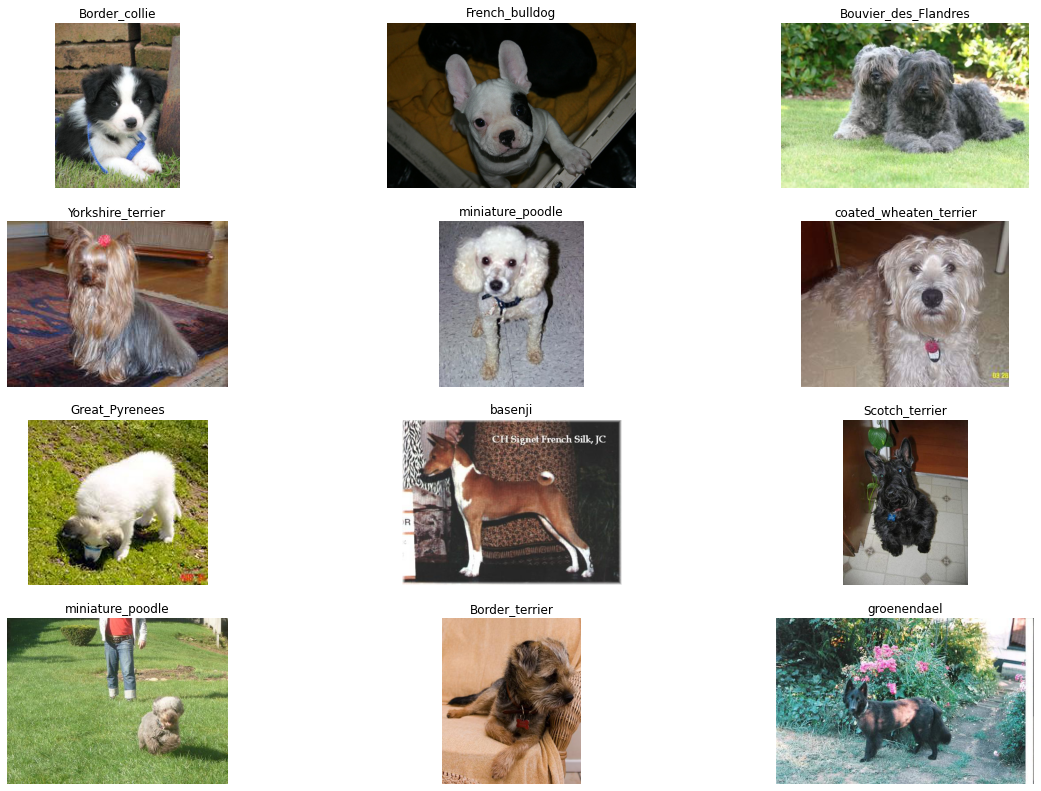

In [ ]:
fig, axis = plt.subplots(4, 3,figsize=(20, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')

plt.show()

In [ ]:
import PIL.Image as Image
image_shape = (224, 224)

dog = Image.open(df.Filepath[0]).resize(image_shape)


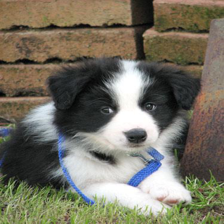

In [ ]:
dog

In [ ]:
dog = np.array(dog)/255.0
dog.shape

(224, 224, 3)

In [ ]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

feature_extractor_model = inception_v3

In [ ]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(feature_extractor_model, input_shape=image_shape+(3,))
])

In [ ]:
result = classifier.predict(dog[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=233>

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


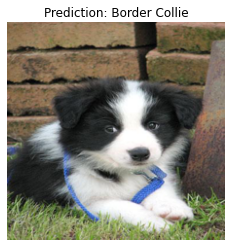

In [ ]:
plt.imshow(dog)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
pd.value_counts(df['Labels'],ascending=False)

coated_retriever        303
Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
                       ... 
Bouvier_des_Flandres    150
Pekinese                149
redbone                 148
Irish_water_spaniel     148
Images                    1
Name: Labels, Length: 120, dtype: int64

In [ ]:
pd.DataFrame(df['Labels'].unique()).to_csv("dog_breeds.csv", index=False, header=False)

In [ ]:
val_ratio = test_ratio = 0.2

train, test = train_test_split(df, test_size=test_ratio, random_state=42)
val, test = train_test_split(test, test_size=val_ratio, random_state=42)
len(train), len(val), len(test)

(16463, 3292, 824)

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip = 'true')


In [ ]:
train_generator=img_datagen.flow_from_dataframe(dataframe=train,
                                                x_col="Filepath",
                                                y_col="Labels",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=True,
                                                target_size=(299, 299))

Found 16463 validated image filenames belonging to 119 classes.


In [ ]:
val_generator=img_datagen.flow_from_dataframe(dataframe=val,
                                              x_col="Filepath",
                                              y_col="Labels",
                                              batch_size=32,
                                              seed=42,
                                              shuffle=True,
                                              target_size=(299, 299))

test_generator=img_datagen.flow_from_dataframe(dataframe=test,
                                               x_col="Filepath",
                                               y_col="Labels",
                                               batch_size=32,
                                               seed=42,
                                               shuffle=True,
                                               target_size=(299, 299))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3291 validated image filenames belonging to 119 classes.
Found 824 validated image filenames belonging to 119 classes.


In [ ]:
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in i_model.layers:
    layer.trainable = False

i_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
model = Sequential()
model.add(i_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(119, activation = 'softmax'))

model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 119)               15351     
                                                                 
Total params: 22,080,407
Trainable params: 277,623
Non-trainable params: 21,802,784
______________________________________

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=cb_early_stopper,
                    epochs=10)

Epoch 1/10
514/514 [==============================] - 7788s 15s/step - loss: 1.1585 - accuracy: 0.7150 - val_loss: 0.7022 - val_accuracy: 0.7938
Epoch 2/10
514/514 [==============================] - 3811s 7s/step - loss: 0.6834 - accuracy: 0.8029 - val_loss: 0.7035 - val_accuracy: 0.7999
Epoch 3/10
514/514 [==============================] - 3801s 7s/step - loss: 0.6156 - accuracy: 0.8173 - val_loss: 0.6738 - val_accuracy: 0.8055
Epoch 4/10
514/514 [==============================] - 3809s 7s/step - loss: 0.5969 - accuracy: 0.8248 - val_loss: 0.6561 - val_accuracy: 0.8134
Epoch 5/10
514/514 [==============================] - 3809s 7s/step - loss: 0.5543 - accuracy: 0.8346 - val_loss: 0.6895 - val_accuracy: 0.8070
Epoch 6/10
514/514 [==============================] - 3813s 7s/step - loss: 0.5412 - accuracy: 0.8427 - val_loss: 0.6311 - val_accuracy: 0.8174
Epoch 7/10
514/514 [==============================] - 3816s 7s/step - loss: 0.5334 - accuracy: 0.8384 - val_loss: 0.6883 - val_accuracy

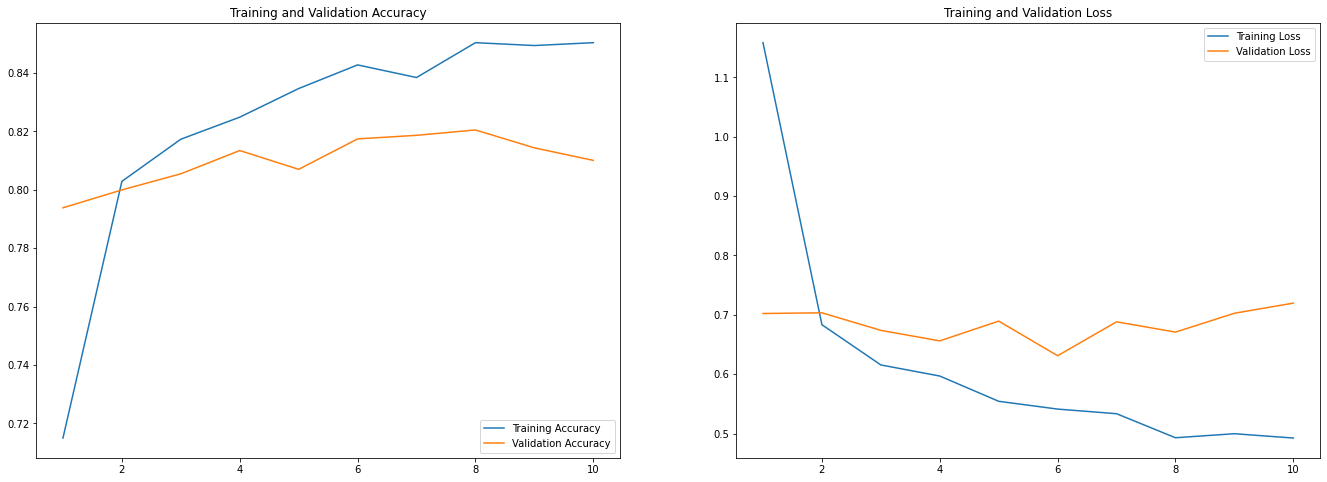

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1)

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_generator,
               steps=STEP_SIZE_TEST)

25/25 [==============================] - 307s 13s/step - loss: 0.6977 - accuracy: 0.8150


[0.6977070569992065, 0.8149999976158142]

In [ ]:
model_score = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model.save("model/dog_breeds_model2.h5")
print("Weights Saved")

25/25 [==============================] - 189s 8s/step - loss: 0.6990 - accuracy: 0.8112
Model Test Loss: 0.6989734768867493
Model Test Accuracy: 0.8112499713897705
Weights Saved
